In [1]:
import pandas as pd
import numpy as np
import torch
import random

## Setup

In [2]:
df_train = pd.read_csv("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/train_set.csv")
df_test = pd.read_csv("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/test_set.csv")
weights_25 = torch.load("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/estimations/weights.pt")
bias_25 = torch.load("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/estimations/bias.pt")


/tmp/ipykernel_1938046/2155574885.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_25 = torch.load("../../data/instruction-induction-data/datamodels/datamodels_06

In [3]:
weights = weights_25.detach().numpy()
bias = bias_25.detach().numpy()

In [4]:
weights.shape

(315, 3885)

In [5]:
df_test["weights"] = list(weights)   
df_test["bias"] = list(bias)


## A1: Show tasks by sample for top weights

In [6]:
from analysis_toolkit import *

In [7]:
df_test["estimation_task"] = df_test["weights"].apply(lambda indices: [df_train.loc[i, "task"] for i in range(len(indices))])


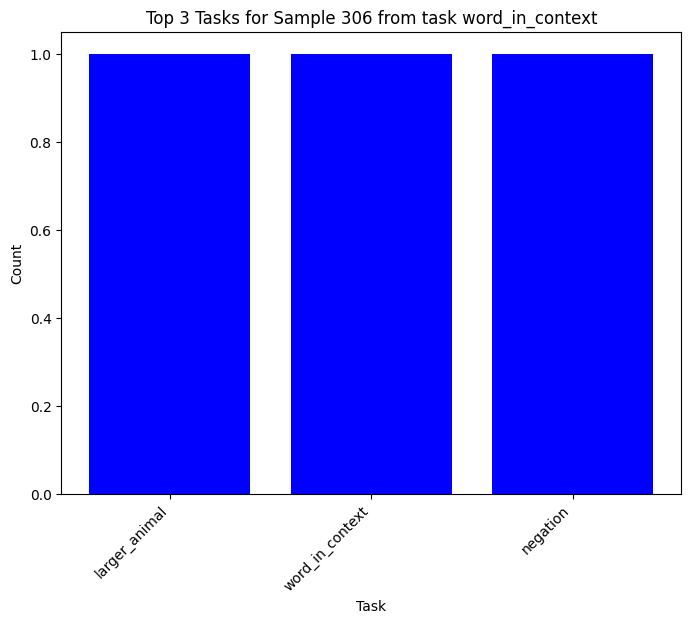

array([ 913, 3738, 1240])

In [8]:
sample = random.randint(0, 315)
top_k = random.randint(3, 10)
show_tasks_by_sample(df_test, sample, top_k)

In [9]:
compare_i_most_high_samples(df_test, df_train, sample, 1)

Sample 306 input: Sentence 1: Thanks to that quack I am a human wreck. Sentence 2: The house was a wreck when they bought it. Word: wreck
Sample 306 output: same
1 Most influential input: bald eagle, shark
1 Most influential output: shark


In [10]:
compare_i_most_high_samples(df_test, df_train, sample, 2)

Sample 306 input: Sentence 1: Thanks to that quack I am a human wreck. Sentence 2: The house was a wreck when they bought it. Word: wreck
Sample 306 output: same
2 Most influential input: Sentence 1: The moon's disk hung in a cloudless sky. Sentence 2: Venus' disk cut off light from the Sun. Word: disk
2 Most influential output: same


In [11]:
compare_i_most_high_samples(df_test, df_train, sample, 3)

Sample 306 input: Sentence 1: Thanks to that quack I am a human wreck. Sentence 2: The house was a wreck when they bought it. Word: wreck
Sample 306 output: same
3 Most influential input: Genghis Khan took Xiliang-fu from the Tanguts in the autumn.
3 Most influential output: Genghis Khan did not take Xiliang-fu from the Tanguts in the autumn.


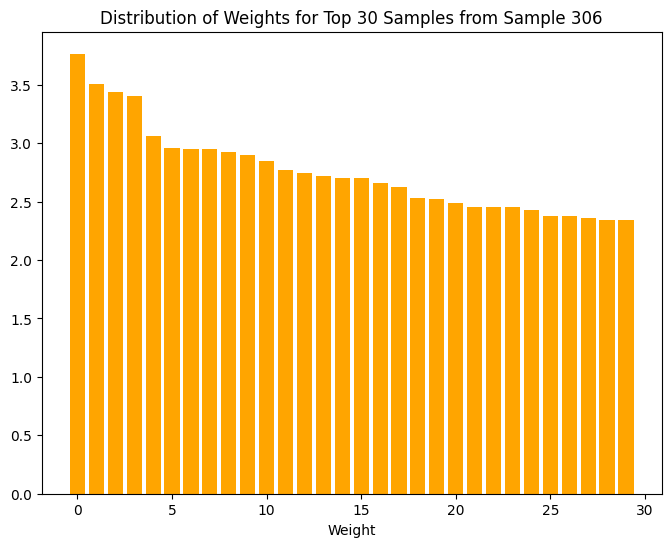

In [12]:
plot_hist_weights(df_test, 30, sample)

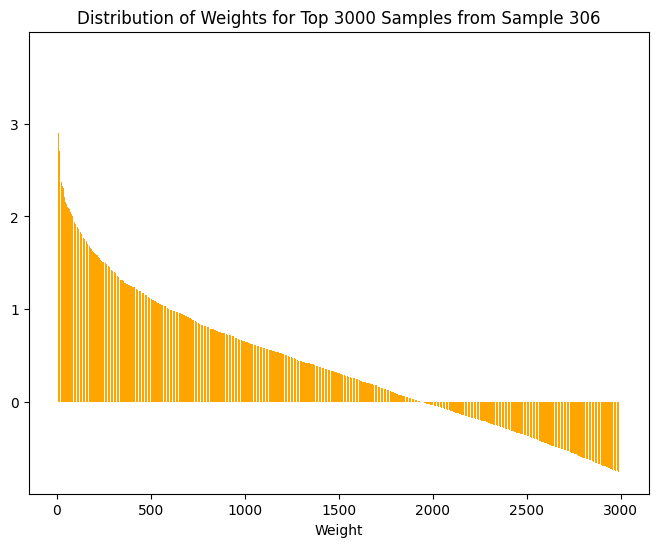

In [13]:
plot_hist_weights(df_test, 3000, sample)

## A2: Analysis by Category

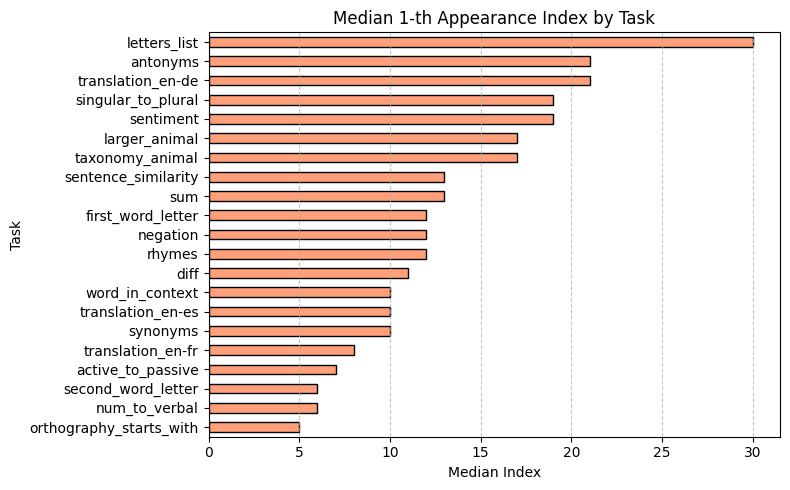

In [14]:
median_category_i_appeareance(df_test, 1)

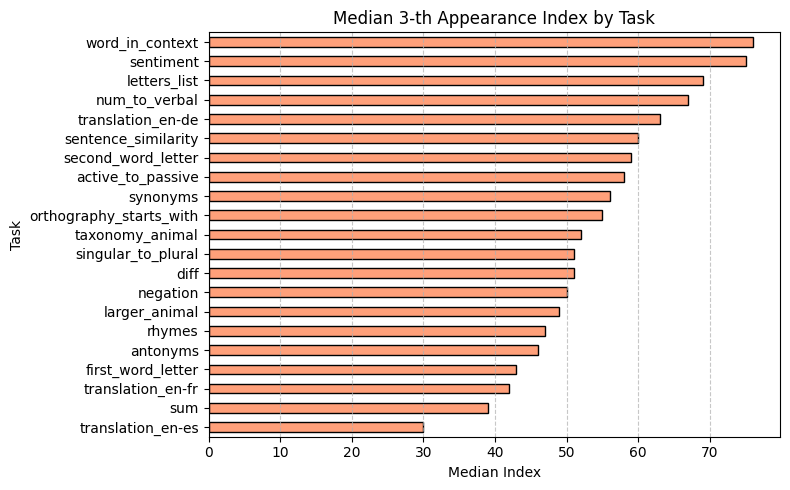

In [15]:
median_category_i_appeareance(df_test, 3)

## A3: Linear Models Evaluation

In [16]:
from src.datamodels.evaluator import LinearRegressorEvaluator
from pathlib import Path
import torch
import pandas as pd
import os


torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


weights = torch.load("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/estimations/weights.pt").to(device="cuda:1")
bias = torch.load("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/estimations/bias.pt").to(device="cuda:1")



# Directory containing your files
directory = Path("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/collections")

# List all files starting with "test_"
files = list(directory.glob("test_*"))

# Combine all files into a single DataFrame
df_list = [pd.read_pickle(file) for file in files]
combined_df = pd.concat(df_list, ignore_index=True)

if torch.cuda.is_available():
    torch.set_default_device("cuda:1")


test_set_eval = torch.tensor(combined_df[["evaluation"]].values, dtype=torch.float32).to(device="cuda:1")
test_set_input = torch.tensor(combined_df[["input"]].values.tolist(), dtype=torch.float32).squeeze(1).to(device="cuda:1")

/home/caio.rhoden/miniconda3/envs/datamodels/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1938046/2254490067.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

In [17]:
evaluator = LinearRegressorEvaluator(
    weights_arr=weights,
    bias_arr=bias,
    targets=test_set_eval,
    inputs=test_set_input,
    metric="mse",
    device=torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
)

In [20]:
evaluator.evaluate(0, 315)

tensor(0.7778, device='cuda:1')
tensor(-2.3998, device='cuda:1')


7.823324203491211

In [ ]:
mse_per_model = evaluator.batch_evaluate([i for i in range(315)], 315)

In [20]:
mse_per_model

tensor([ 7.8233, 11.1925, 10.7308, 10.4050,  9.8674,  9.1784, 12.7046, 10.3878,
        12.3458,  7.9212,  9.4700,  8.1866,  9.2180,  9.6748,  8.1663,  8.8584,
         7.2660,  8.1978,  8.4692,  8.6227,  7.7928,  7.2732,  9.1911,  7.2159,
        10.2498,  9.5321, 12.2008,  8.5012, 10.5899,  9.7660,  9.3765,  7.2438,
         8.8565, 10.2939,  7.4485, 11.9759, 11.1581, 10.7287,  8.4886,  9.4439,
         9.1044,  8.9575, 12.2204, 11.8437, 10.0396,  9.2061,  9.5681,  7.8436,
         7.6036,  8.9729,  8.3979,  8.7555,  9.6655,  8.9076,  7.9383,  8.5280,
         8.3054,  7.7866,  8.6865,  9.2037,  9.3498,  9.2463,  8.5065,  7.2305,
        10.3669, 11.0012, 10.3866,  7.4784,  7.9082,  8.8000,  7.7450,  8.3757,
         9.0357,  7.3930,  7.7465,  8.4218,  7.4916,  8.4625,  8.9009,  9.3559,
         7.7798,  7.3998,  8.1856,  8.6135,  9.7889,  9.4717,  9.4564,  7.9413,
        14.3938,  9.2207,  8.8951,  8.4837, 10.8695,  9.4503, 13.1182,  8.7651,
         9.4569,  6.5710, 10.5684,  8.24